In [1]:
import ete3
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import pickle as pkl
from scipy.spatial.distance import braycurtis
import os

%cd ~/Dropbox (MIT)/IndexHGTAnalysis/modeldata/

/Users/thiberio/Dropbox (MIT)/IndexHGTAnalysis/modeldata


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
def assess_constraint_compatibility(constraint):
    older_bound   = next( named_tree.iter_search_nodes(name=constraint.donor_node) )
    younger_bound = next( named_tree.iter_search_nodes(name=constraint.recipient_node) )
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [4]:
named_tree = ete3.Tree('Cyano_modelBB_ugam_bd_7_20_sample.labels', format=1)

In [5]:
BH_ugam_bd_1k_posterior_trees   = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_ugam_bd_1k_7_20_sample.datedist').readlines()]
BH_ugam_nobd_1k_posterior_trees = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_ugam_nobd_1k_7_20_sample.datedist').readlines()]
BH_cir_bd_10k_posterior_trees   = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_cir_bd_7_20_sample10k.datedist').readlines()]
BH_cir_nobd_10k_posterior_trees = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_cir_nobd_7_20_sample10k.datedist').readlines()]
BH_ln_bd_10k_posterior_trees    = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_ln_bd_7_20_sample10k.datedist').readlines()]
BH_ln_nobd_10k_posterior_trees  = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBH_ln_nobd_7_20_sample10k.datedist').readlines()]

In [6]:
results_from_BH_models = {'ugam_bd':  BH_ugam_bd_1k_posterior_trees,
                          'ugam_nobd':BH_ugam_nobd_1k_posterior_trees,
                          'cir_bd':   BH_cir_bd_10k_posterior_trees,
                          'cir_nobd': BH_cir_nobd_10k_posterior_trees,
                          'ln_bd':    BH_ln_bd_10k_posterior_trees,
                          'ln_nobd':  BH_ln_nobd_10k_posterior_trees}

In [7]:
HGT_constraints = pd.read_excel('HGTgpf4a.xlsx', sep=',')

HGT_constraints.donor_node     = HGT_constraints.donor_node.astype(str)
HGT_constraints.recipient_node = HGT_constraints.recipient_node.astype(str)

In [8]:
HGT_constraints.head()

,donor_node,recipient_node,index,label,COG_names,COG_numbers,donor_clade,recipient_clade
0,324,275,0,1BC,2515/1-aminocyclopropane-1-carboxylate deaminase,2515,Sphingobacteriales/Cytophagales,Nostocales
1,324,268,1,2BC,0590/tRNA wobble adenosine to inosine editing,0590,Sphingobacteriales/Cytophagales,Nostocales/Chroococcidiopsidales
2,324,217,2,3BC,0590/tRNA wobble adenosine to inosine editing,0590,Sphingobacteriales/Cytophagales,Thermosynechococcus/Cyanothece
3,313,239,3,4BC,2942/2-epimerase,2942,Bacteroidales/Flavobacteriales,Nostocales/Oscilliatoriales/Chroococcidiopsida...
4,324,281,4,5BC,2603/tRNA 2-selenouridine synthase activity,2603,Sphingobacteriales/Cytophagales,Marine SynPro/Cyanobium group


In [9]:
if os.path.isfile('BH_compatibility_tables.pkl'):
    with open('BH_compatibility_tables.pkl', 'rb') as input_handle:
        BH_compatibility_tables = pkl.load( input_handle )

else:
    BH_compatibility_tables = {}

    for model_name, posterior_trees in results_from_BH_models.items():
        BH_compatibility_tables[model_name] = pd.DataFrame()

        for index, row in HGT_constraints.iterrows():
            BH_compatibility_tables[model_name][row.label] = assess_constraint_compatibility( row )

    with open('BH_compatibility_tables.pkl', 'wb') as out:
        pkl.dump(BH_compatibility_tables, out)

In [10]:
overall_BH_contraint_compatibity = pd.DataFrame( index  =BH_compatibility_tables.keys(),
                                                 columns=BH_compatibility_tables['ugam_bd'].columns )

#
# calculate Bray-Curtis from relative counts. It is not the perfect scenario, but it is less sensitive to sampling sizes
#     (http://www.econ.upf.edu/~michael/stanford/maeb5.pdf)
#
for model_name, tmp_compatibility in BH_compatibility_tables.items():
    
    norm_factor = None
    if model_name.startswith('ugam_'):
        norm_factor = 1_000.0
    elif model_name.startswith('cir_'):
        norm_factor = 10_000.0
    elif model_name.startswith('ln_'):
        norm_factor = 10_666.0
        
    overall_BH_contraint_compatibity.loc[model_name] = tmp_compatibility.sum() / norm_factor

overall_BH_contraint_compatibity = overall_BH_contraint_compatibity.astype(np.float64)
overall_BH_contraint_compatibity.rename(index={'ugam_bd'  :'UGam BD',
                                               'ugam_nobd':'UGam noBD',
                                               'cir_bd'   :'CIR BD',
                                               'cir_nobd' :'CIR noBD',
                                               'ln_bd'    :'LN BD',
                                               'ln_nobd'  :'LN noBD'}, 
                                        inplace=True)
# overall_BH_contraint_compatibity['4BG'] = 1e-10

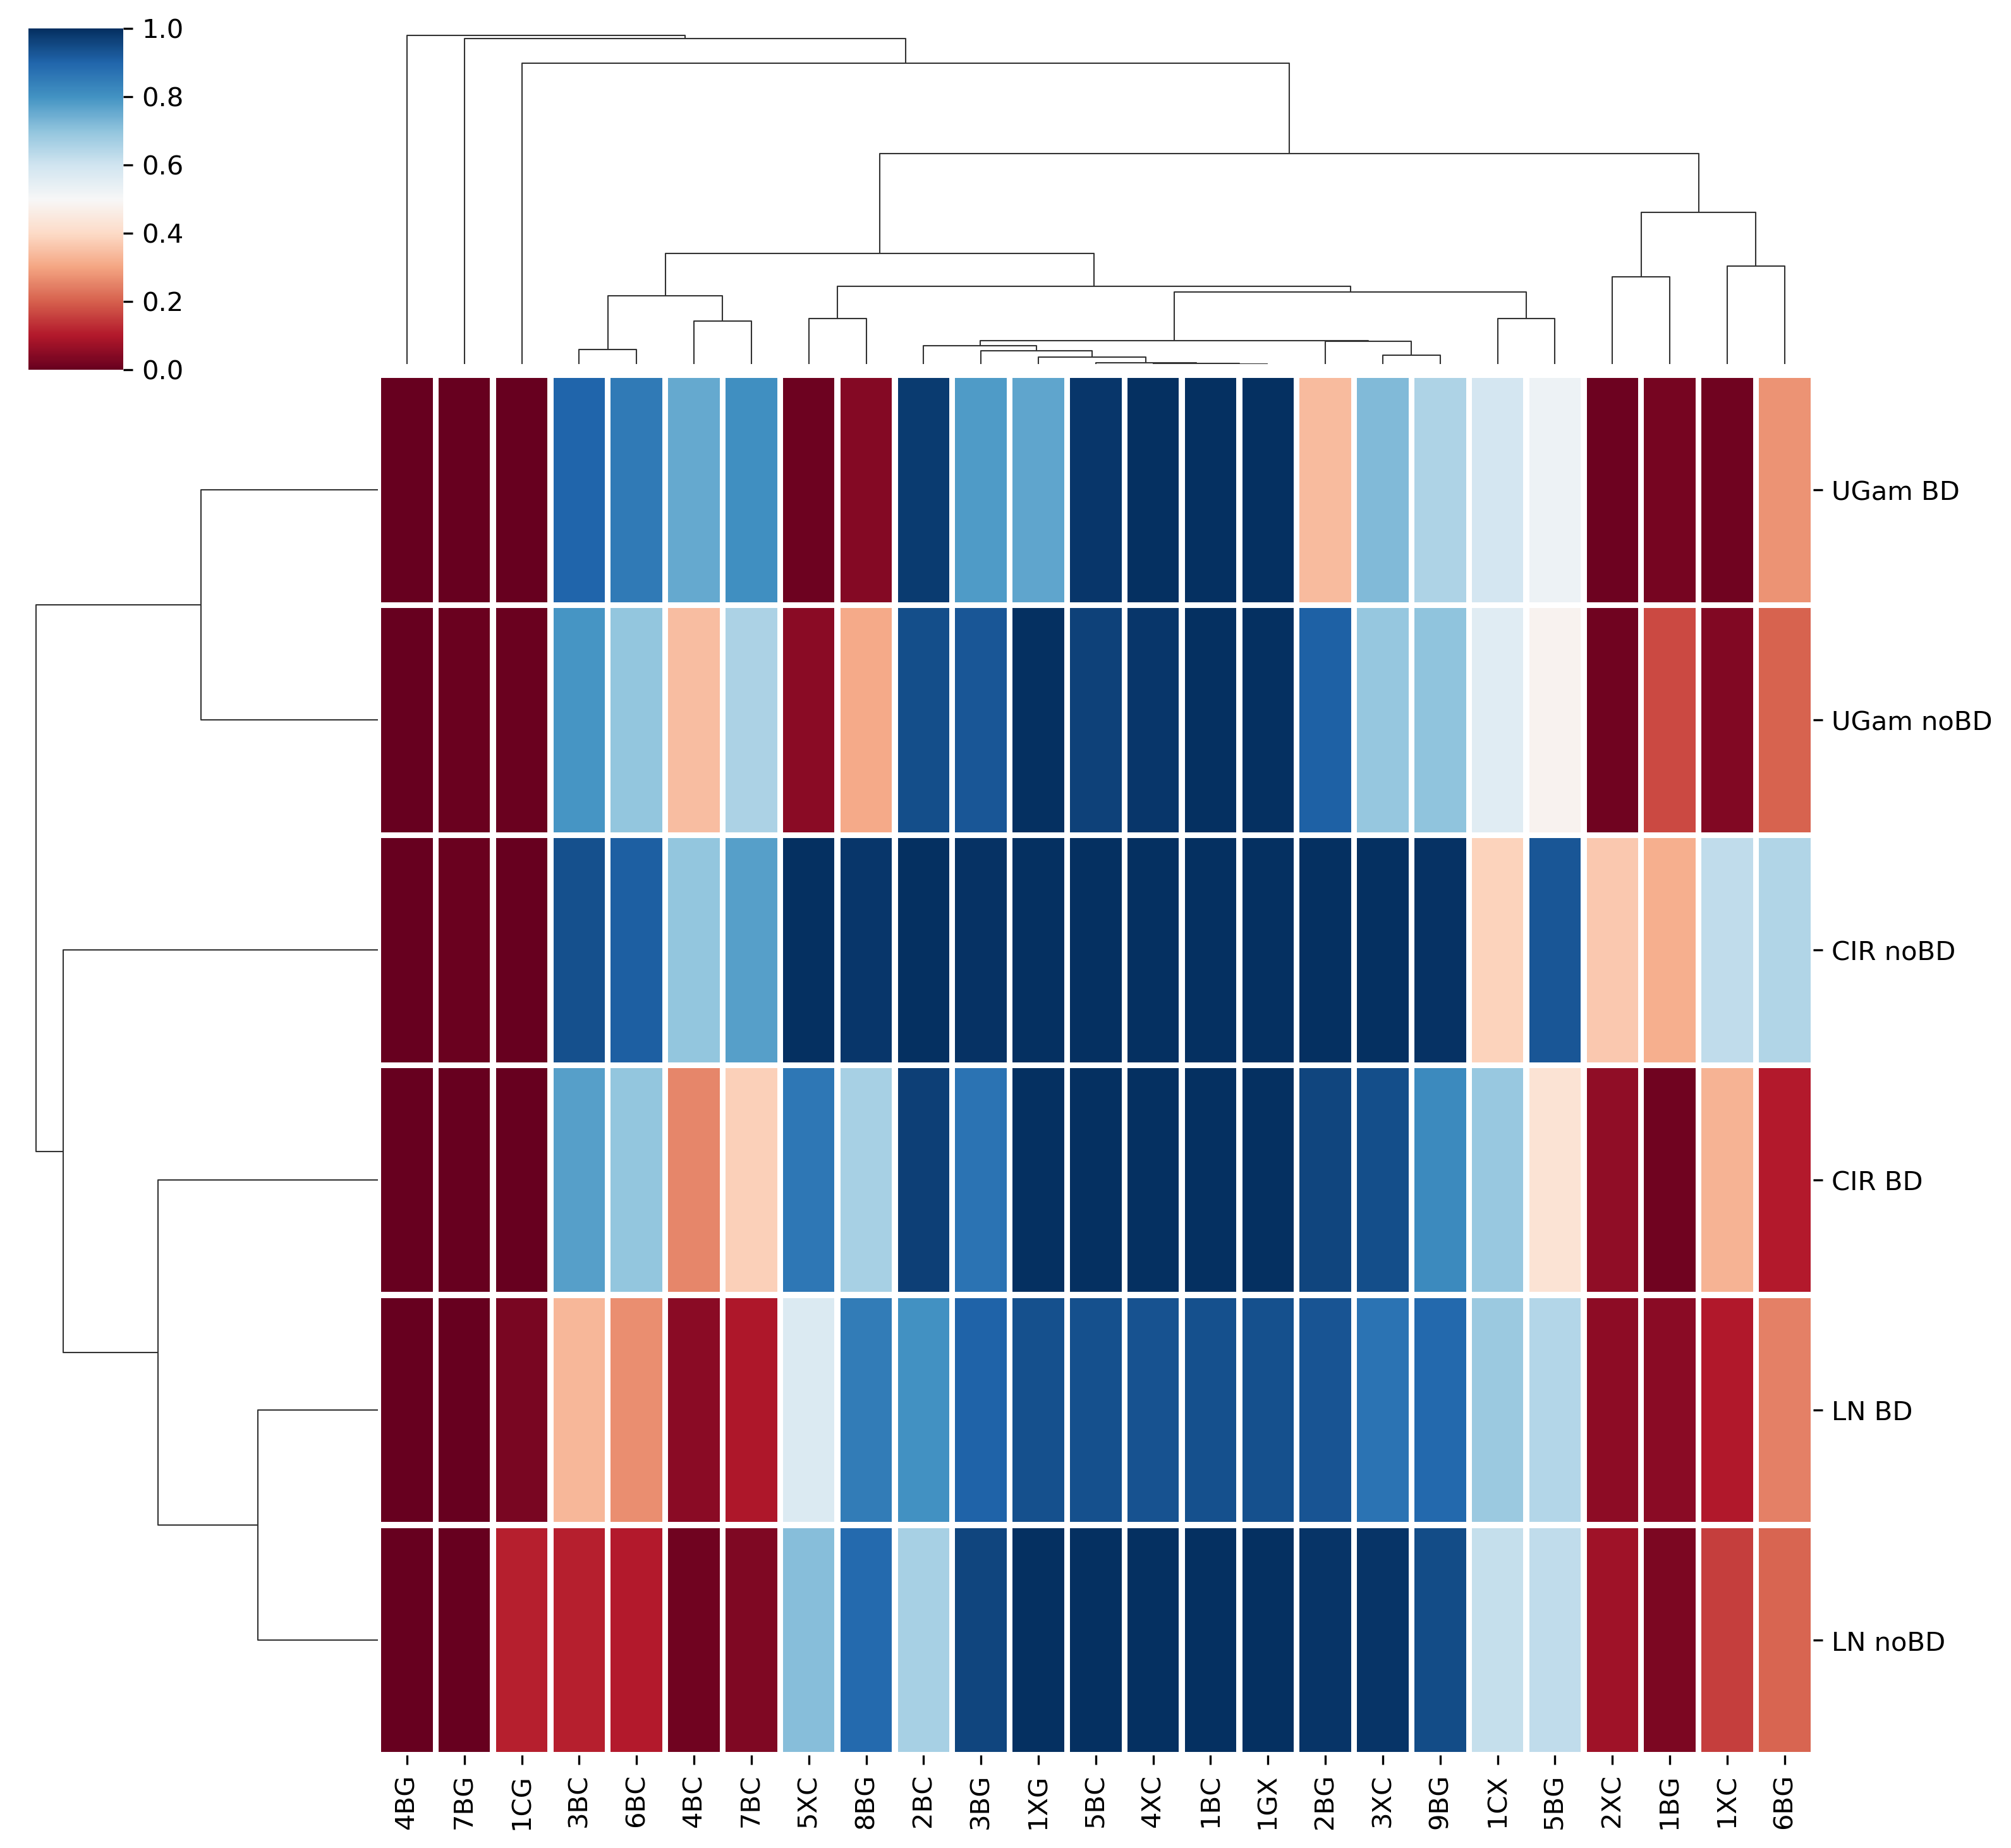

In [11]:
model_linkage      = hierarchy.linkage(overall_BH_contraint_compatibity,   method='average', metric='braycurtis')
constraint_linkage = hierarchy.linkage(overall_BH_contraint_compatibity.T, method='average', metric='braycurtis')

clst_map = sns.clustermap(overall_BH_contraint_compatibity,
                          row_linkage=model_linkage,
                          col_linkage=constraint_linkage,
                          cmap='RdBu',
                          linewidths=2,
                          xticklabels=True,
                          yticklabels=True)

clst_map.ax_heatmap.set_ylim(6, 0)
plt.setp(clst_map.ax_heatmap.yaxis.get_majorticklabels(), 
         rotation=0)
clst_map.fig.set_dpi(300)

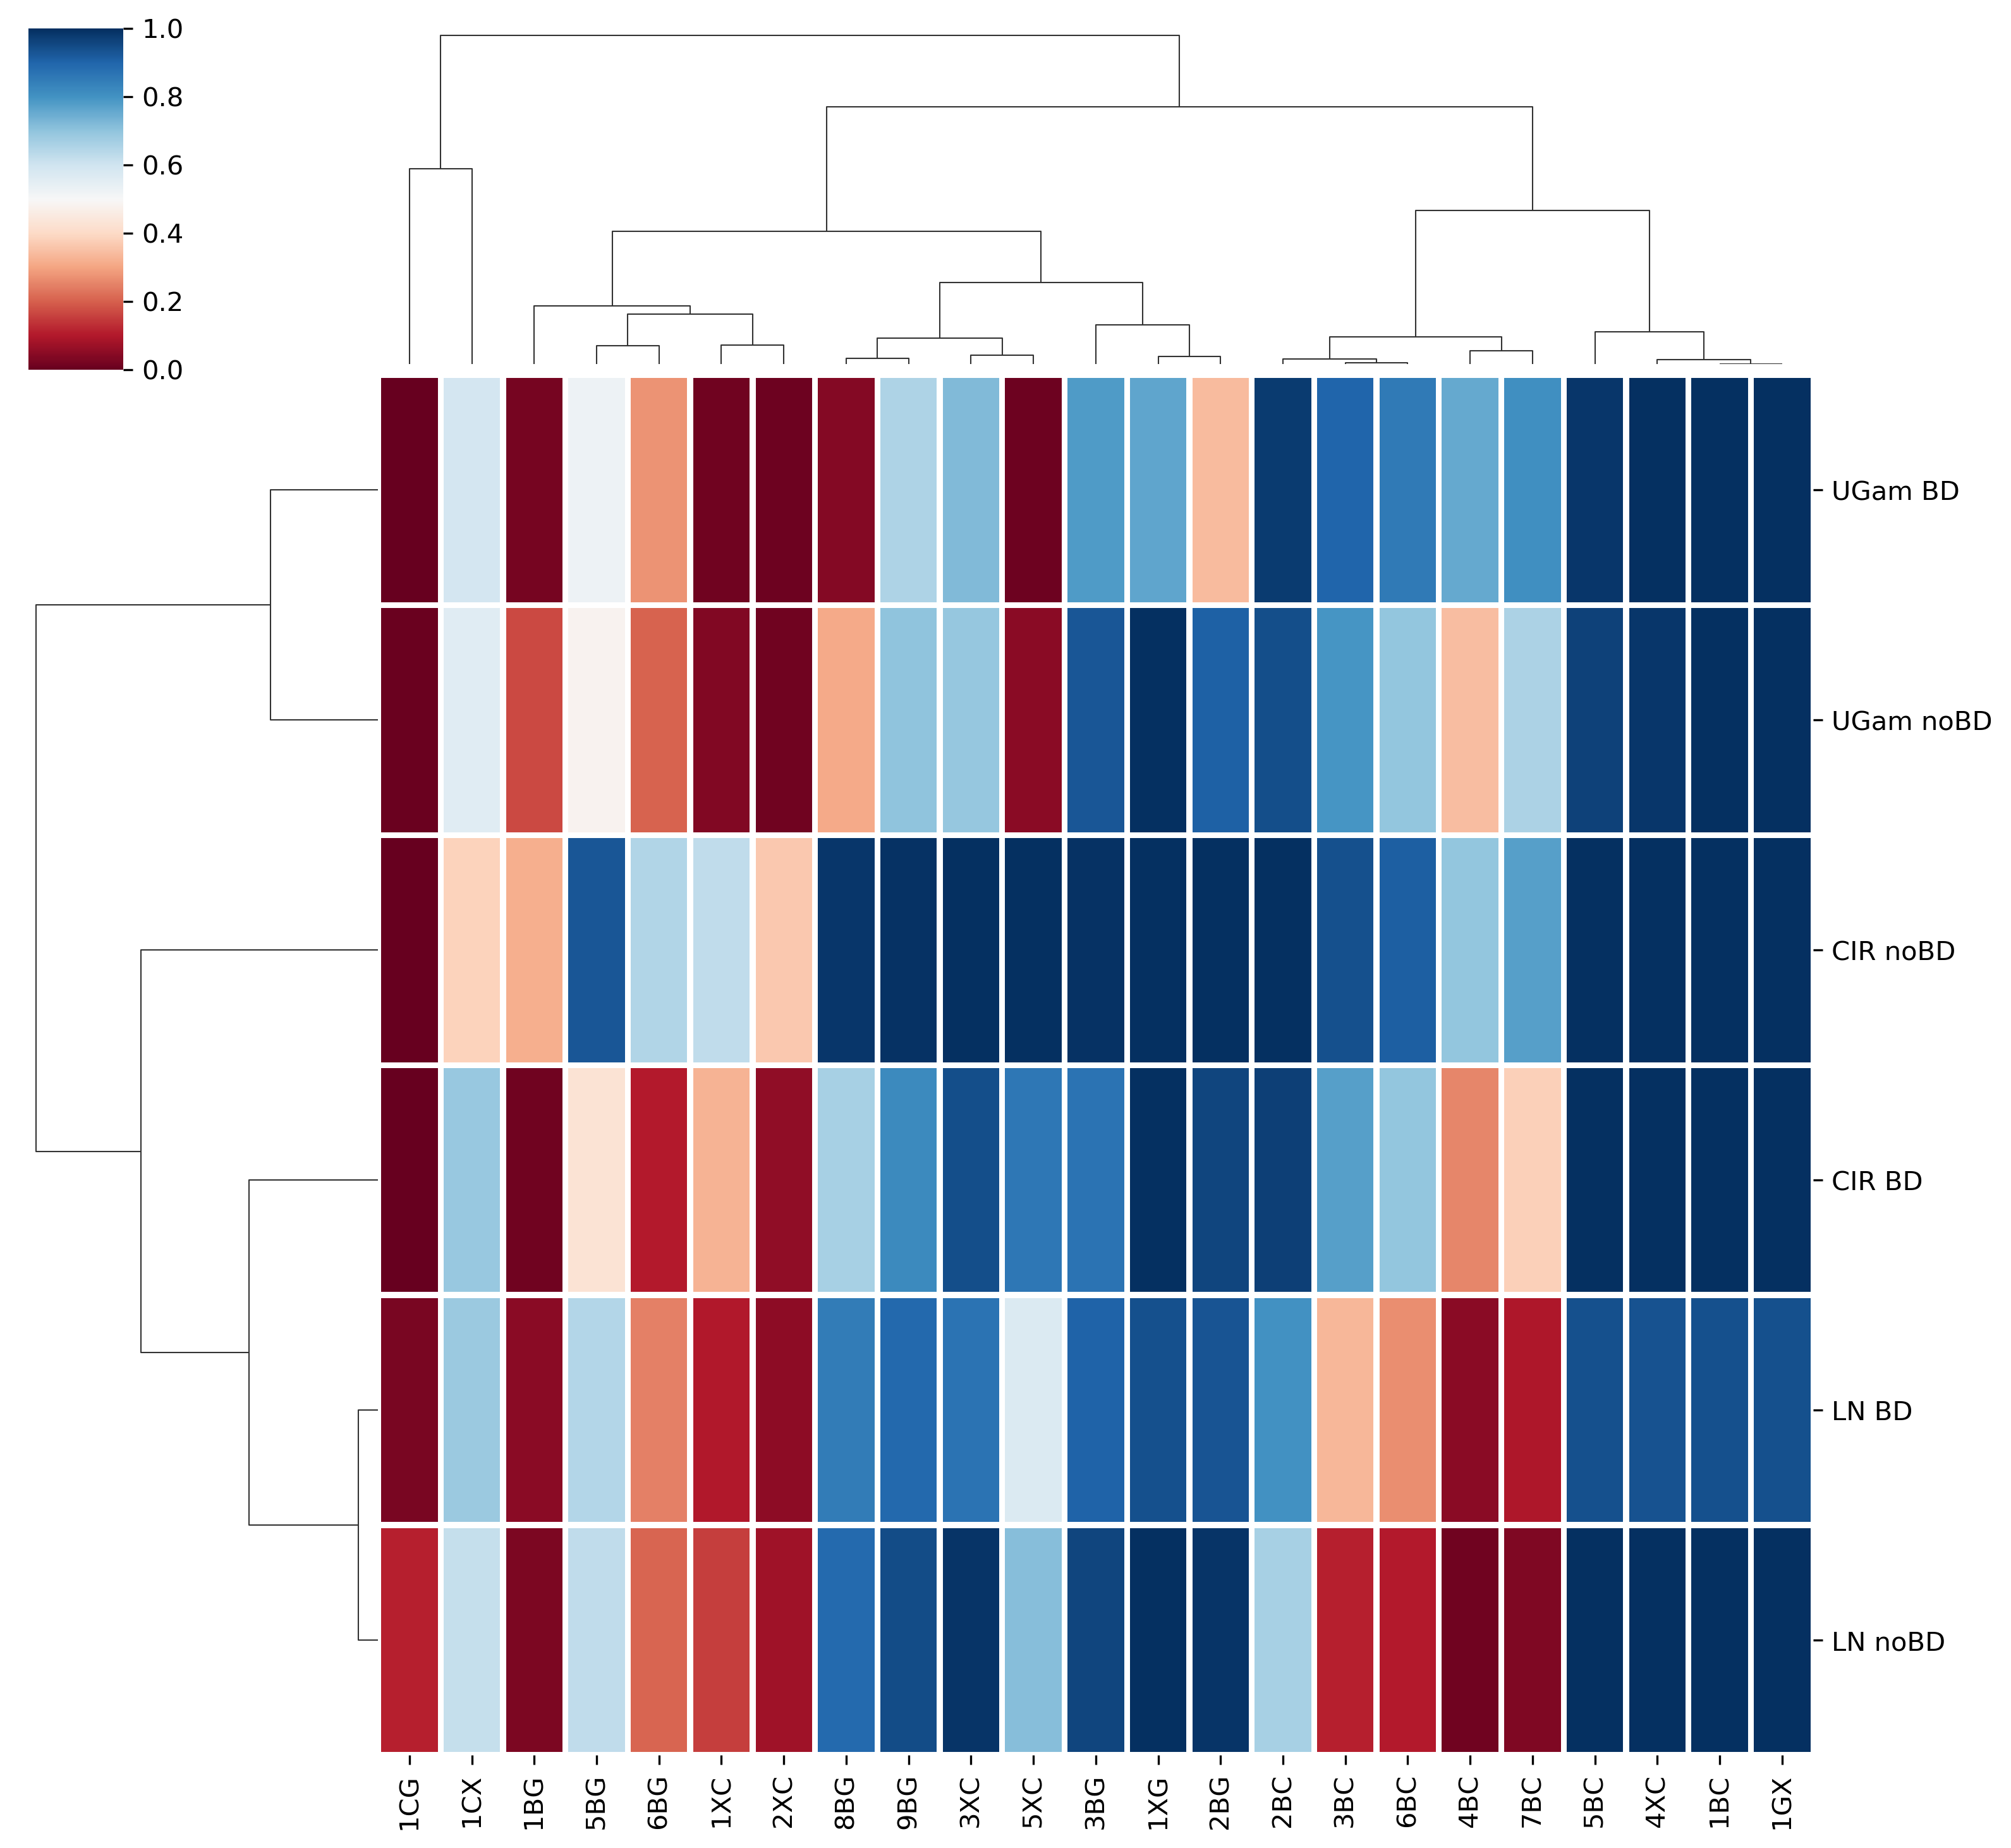

In [12]:
overall_BH_contraint_compatibity.drop(columns=['4BG', '7BG'], inplace=True)

model_linkage      = hierarchy.linkage(overall_BH_contraint_compatibity,   method='average', metric='correlation')
constraint_linkage = hierarchy.linkage(overall_BH_contraint_compatibity.T, method='average', metric='correlation')

clst_map = sns.clustermap(overall_BH_contraint_compatibity,
#                           method='average', metric='braycurtis',
                          row_linkage=model_linkage,
                          col_linkage=constraint_linkage,
                          cmap='RdBu',
                          linewidths=2,
                          xticklabels=True,
                          yticklabels=True)

#
# both matplotlib and its solution are bugged!
#    (the solution works, but it is the opposite of what it should be, bottom and top)
#    https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot/58165593#58165593
#
clst_map.ax_heatmap.set_ylim(6, 0)

plt.setp(clst_map.ax_heatmap.yaxis.get_majorticklabels(), 
         rotation=0)
clst_map.fig.set_dpi(300)

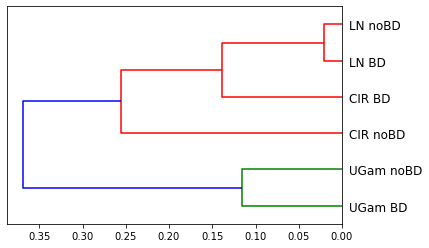

In [13]:
hierarchy.dendrogram(model_linkage, 
                     orientation='left',
                     labels=overall_BH_contraint_compatibity.index);

In [14]:
BE_ugam_bd_1k_posterior_trees   = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_ugam_bd_1k_7_20_sample.datedist').readlines()]
BE_ugam_nobd_1k_posterior_trees = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_ugam_nobd_1k_7_20_sample.datedist').readlines()]
BE_cir_bd_10k_posterior_trees   = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_cir_bd_longrun_7_20_sample.datedist').readlines()]
BE_cir_nobd_10k_posterior_trees = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_cir_nobd_longrun_7_20_sample.datedist').readlines()]
BE_ln_bd_10k_posterior_trees    = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_ln_bd_longrun_7_20_sample.datedist').readlines()]
BE_ln_nobd_10k_posterior_trees  = [ete3.Tree(line) 
                                   for line in open('Cyano_modelBE_ln_nobd_longrun_7_20_sample.datedist').readlines()]

In [15]:
results_from_BE_models = {'ugam_bd':  BE_ugam_bd_1k_posterior_trees,
                          'ugam_nobd':BE_ugam_nobd_1k_posterior_trees,
                          'cir_bd':   BE_cir_bd_10k_posterior_trees,
                          'cir_nobd': BE_cir_nobd_10k_posterior_trees,
                          'ln_bd':    BE_ln_bd_10k_posterior_trees,
                          'ln_nobd':  BE_ln_nobd_10k_posterior_trees}

In [16]:
if os.path.isfile('BE_compatibility_tables.pkl'):
    with open('BE_compatibility_tables.pkl', 'rb') as input_handle:
        BE_compatibility_tables = pkl.load( input_handle )

else:
    BE_compatibility_tables = {}

    for model_name, posterior_trees in results_from_BE_models.items():
        BE_compatibility_tables[model_name] = pd.DataFrame()

        for index, row in HGT_constraints.iterrows():
            BE_compatibility_tables[model_name][row.label] = assess_constraint_compatibility( row )

    with open('BE_compatibility_tables.pkl', 'wb') as out:
        pkl.dump(BE_compatibility_tables, out)

In [17]:
overall_BE_contraint_compatibity = pd.DataFrame( index  =BE_compatibility_tables.keys(),
                                                 columns=BE_compatibility_tables['ugam_bd'].columns )

#
# calculate Bray-Curtis from relative counts. It is not the perfect scenario, but it is less sensitive to sampling sizes
#     (http://www.econ.upf.edu/~michael/stanford/maeb5.pdf)
#
for model_name, tmp_compatibility in BE_compatibility_tables.items():
    
    norm_factor = None
    if model_name.startswith('ugam_'):
        norm_factor = 1_000.0
    elif model_name.startswith('cir_'):
        norm_factor = 10_000.0
    elif model_name.startswith('ln_'):
        norm_factor = 10_000.0
        
    overall_BE_contraint_compatibity.loc[model_name] = tmp_compatibility.sum() / norm_factor

overall_BE_contraint_compatibity = overall_BE_contraint_compatibity.astype(float)
overall_BE_contraint_compatibity.rename(index={'ugam_bd'  :'UGam BD',
                                               'ugam_nobd':'UGam noBD',
                                               'cir_bd'   :'CIR BD',
                                               'cir_nobd' :'CIR noBD',
                                               'ln_bd'    :'LN BD',
                                               'ln_nobd'  :'LN noBD'}, 
                                        inplace=True)

In [18]:
overall_BE_contraint_compatibity

,1BC,2BC,3BC,4BC,5BC,6BC,7BC,1CG,1GX,1XG,...,5XC,1BG,2BG,3BG,4BG,5BG,6BG,7BG,8BG,9BG
UGam BD,0.994,0.6360,0.8890,0.0030,0.884,0.6840,0.6920,0.2150,1.0,0.8260,...,0.0170,0.0900,0.5440,0.7800,0.0,0.4650,0.2020,0.0020,0.0960,0.6180
UGam noBD,0.994,0.6640,0.7850,0.0060,0.904,0.4720,0.5240,0.3320,1.0,0.9870,...,0.0760,0.2130,0.8150,0.8400,0.0,0.4150,0.1670,0.0120,0.2500,0.6180
CIR BD,1.000,0.8938,0.5923,0.0007,1.000,0.0844,0.0538,0.0002,1.0,1.0000,...,0.9466,0.0141,0.9992,0.9913,0.0,0.6298,0.1822,0.0000,0.8946,0.9745
CIR noBD,1.000,0.9429,0.7422,0.0241,1.000,0.3989,0.2255,0.0005,1.0,1.0000,...,0.9986,0.1471,0.9999,0.9993,0.0,0.9069,0.5824,0.0015,0.9836,0.9953
LN BD,1.000,0.8517,0.3481,0.0080,1.000,0.1717,0.0406,0.0020,1.0,0.9992,...,0.5941,0.0533,0.9981,0.9648,0.0,0.6051,0.2106,0.0006,0.8855,0.9554
LN noBD,1.000,0.8113,0.3039,0.0145,1.000,0.1489,0.0296,0.0110,1.0,1.0000,...,0.7614,0.0662,0.9966,0.9674,0.0,0.6773,0.2780,0.0015,0.9232,0.9635


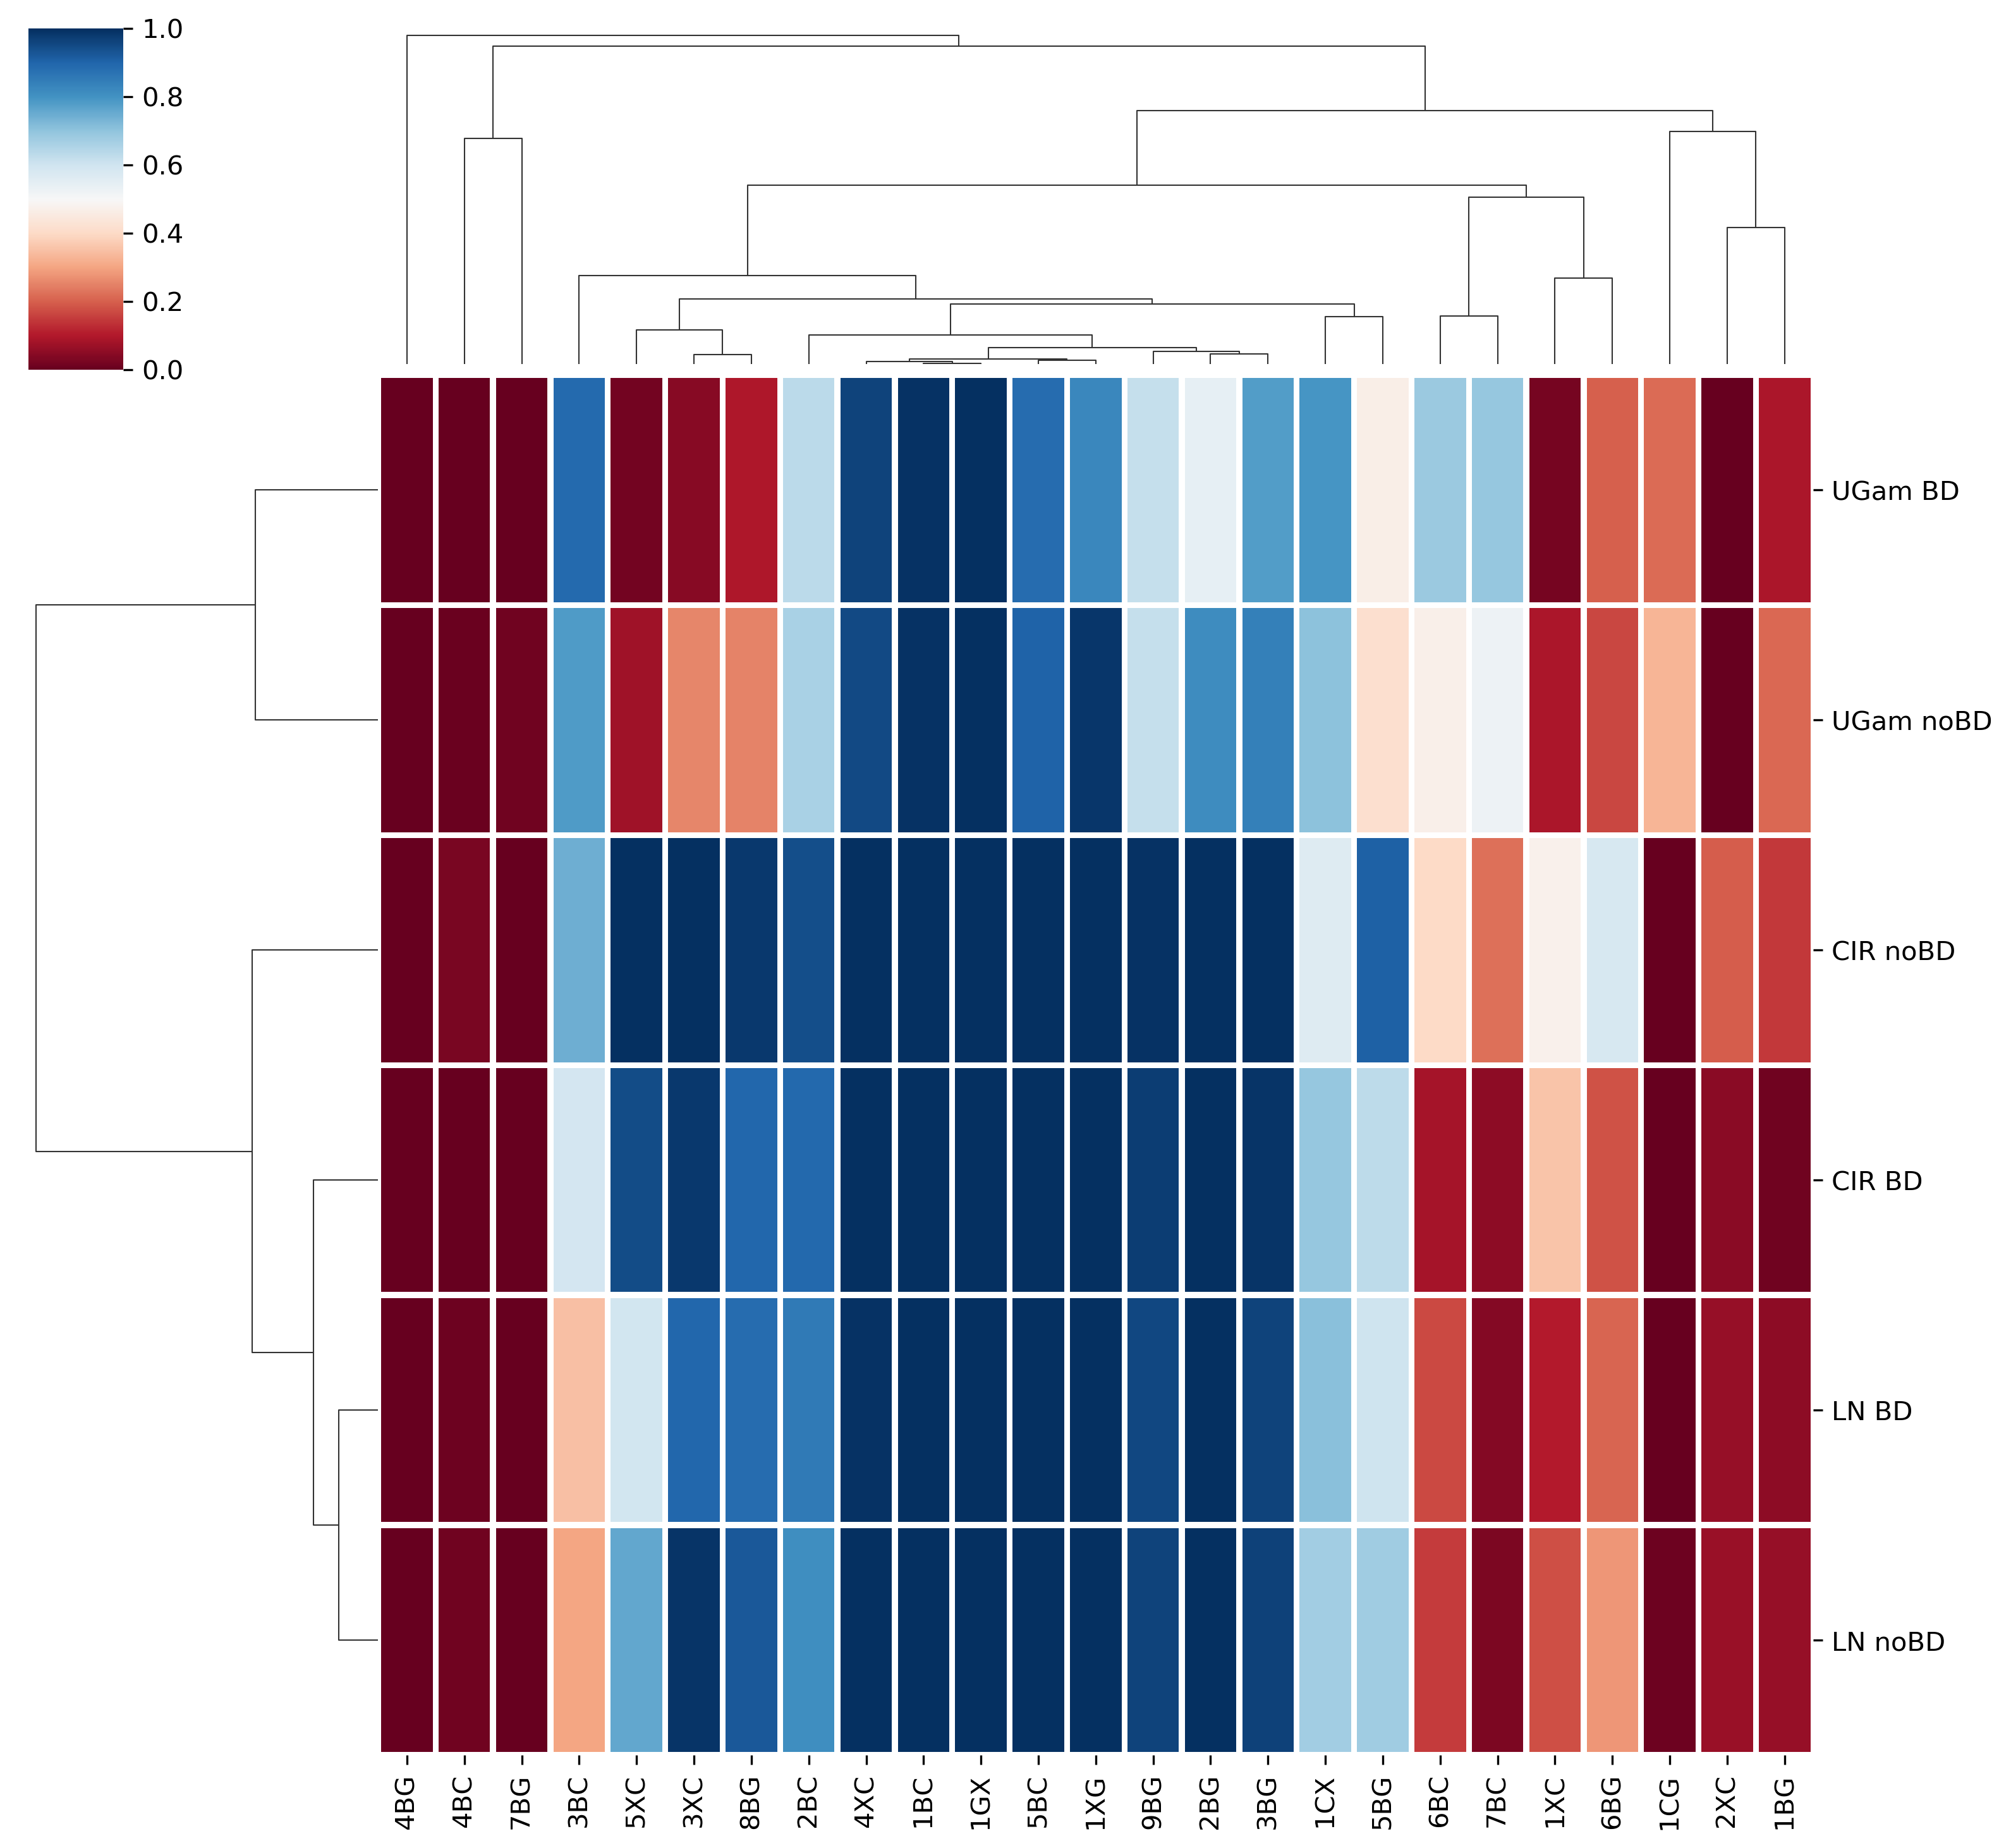

In [19]:
model_linkage      = hierarchy.linkage(overall_BE_contraint_compatibity,   method='average', metric='braycurtis')
constraint_linkage = hierarchy.linkage(overall_BE_contraint_compatibity.T, method='average', metric='braycurtis')

clst_map = sns.clustermap(overall_BE_contraint_compatibity,
                          row_linkage=model_linkage,
                          col_linkage=constraint_linkage,
                          cmap='RdBu',
                          linewidths=2,
                          xticklabels=True,
                          yticklabels=True)

clst_map.ax_heatmap.set_ylim(6, 0)
plt.setp(clst_map.ax_heatmap.yaxis.get_majorticklabels(), 
         rotation=0)
clst_map.fig.set_dpi(300)